In [ ]:
pip install pillow opencv-python numpy pandas opencv-python scikit-image

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import cv2
import numpy as np
from PIL import Image
import pandas as pd
from skimage.feature import hog, local_binary_pattern

# Paths
base_path = 'data/train'
output_csv = 'features.csv'

# Categories for labeled data
categories = {
    'with_label/clean': 'clean',
    'with_label/dirty': 'dirty',
    'no_label': 'unknown'
}

# LBP parameters
LBP_RADIUS = 1
LBP_N_POINTS = 8 * LBP_RADIUS
LBP_METHOD = 'uniform'
LBP_N_BINS = LBP_N_POINTS + 2

# HOG parameters
HOG_PIXELS_PER_CELL = (8, 8)
HOG_CELLS_PER_BLOCK = (2, 2)
HOG_ORIENTATIONS = 9

features = []

def extract_features(img_path, label):
    try:
        # Load & preprocess
        img = Image.open(img_path)
        width, height = img.size
        img_cv = cv2.imread(img_path)
        img_resized = cv2.resize(img_cv, (128, 128))

        # File size
        file_size_kb = os.path.getsize(img_path) / 1024.0

        # Average RGB
        img_np = np.array(img.resize((128, 128)))
        avg_color = img_np.mean(axis=(0,1))[:3]

        # Grayscale
        gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)

        # Grayscale hist (first 20 bins)
        gray_hist = cv2.calcHist([gray],[0],None,[256],[0,256]).flatten()[:20]

        # Perceptual luminance hist (first 20 bins)
        luminance = (0.299*img_np[:,:,0] + 0.587*img_np[:,:,1] + 0.114*img_np[:,:,2]).astype(np.uint8)
        lum_hist = cv2.calcHist([luminance],[0],None,[256],[0,256]).flatten()[:20]

        # Contrast
        contrast = int(gray.max() - gray.min())

        # Canny edges
        canny = cv2.Canny(gray,100,200)
        canny_count = int((canny>0).sum())

        # Sobel edges
        sobelx = cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=3)
        sobely = cv2.Sobel(gray,cv2.CV_64F,0,1,ksize=3)
        sobel_mag = np.sqrt(sobelx**2 + sobely**2).astype(np.uint8)
        sobel_count = int((sobel_mag>50).sum())

        # Center vs Surround edges
        cx, cy = 64, 64
        half = 32
        center_mask = np.zeros_like(gray, dtype=bool)
        center_mask[cy-half:cy+half, cx-half:cx+half] = True

        center_edges = int((canny[center_mask]>0).sum())
        surround_edges = int((canny[~center_mask]>0).sum())

        # HOG (take first 50 dims)
        hog_feats = hog(gray,
                        orientations=HOG_ORIENTATIONS,
                        pixels_per_cell=HOG_PIXELS_PER_CELL,
                        cells_per_block=HOG_CELLS_PER_BLOCK,
                        block_norm='L2-Hys',
                        feature_vector=True)[:50]

        # LBP (first 20 bins)
        lbp = local_binary_pattern(gray, LBP_N_POINTS, LBP_RADIUS, method=LBP_METHOD)
        lbp_hist, _ = np.histogram(lbp.ravel(), bins=LBP_N_BINS, range=(0, LBP_N_BINS))
        lbp_hist = (lbp_hist.astype("float") / (lbp_hist.sum()+1e-6))[:20]

        # Assemble
        feat = {
            'file': os.path.basename(img_path),
            'label': label,
            'width': width,
            'height': height,
            'file_size_kb': round(file_size_kb,2),
            'avg_r': round(avg_color[0],2),
            'avg_g': round(avg_color[1],2),
            'avg_b': round(avg_color[2],2),
            'contrast': contrast,
            'canny_edge_count': canny_count,
            'sobel_edge_count': sobel_count,
            'center_edge_count': center_edges,
            'surround_edge_count': surround_edges
        }

        # add histograms
        for i, v in enumerate(gray_hist):     feat[f'gray_hist_{i}'] = int(v)
        for i, v in enumerate(lum_hist):      feat[f'lum_hist_{i}'] = int(v)
        for i, v in enumerate(hog_feats):     feat[f'hog_{i}'] = float(v)
        for i, v in enumerate(lbp_hist):      feat[f'lbp_{i}'] = float(v)

        return feat

    except Exception as e:
        print(f"Error on {img_path}: {e}")
        return None

# Main loop
for rel, lbl in categories.items():
    folder = os.path.join(base_path, rel)
    for fn in os.listdir(folder):
        if fn.lower().endswith(('.jpg','.png','.jpeg')):
            data = extract_features(os.path.join(folder, fn), lbl)
            if data: features.append(data)

# Save
df = pd.DataFrame(features)
df.to_csv(output_csv, index=False)
print(f"Saved {len(features)} rows to {output_csv}")


Saved 600 rows to features.csv


In [5]:
pip install scikit-learn


Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/10.7 MB ? eta -:--:--
    --------------------------------------- 0.3/10.7 MB ? eta -:--:--
   --- ------------------------------------ 1.0/10.7 MB 3.6 MB/s eta 0:00:03
   ------ --------------------------------- 1.8/10.7 MB 4.1 MB/s eta 0:00:03
   --------- ------------------------------ 2.6/10.7 MB 3.9 MB/s eta 0:00:03
   -------------- ------------------------- 3.9/10.7 MB 4.3 MB/s eta 0:00:02
   ------------------ --------------------- 5.0/10.7 MB 4.7 MB/s eta 0:00:02
   ------------------------ --------------- 6.6/10.7 MB 5.0 MB/s eta 0:00:01
   ---------------------------- ----------- 7.6/10.7 MB 5.1 MB/s eta 0:00:01
   ---------------------------------- ----- 9.2/10.7 MB 5.3 MB/s eta 0:00:01
   -------------------------------------- - 10.2/10.7 MB 5.3 MB/s eta 0:00:01
   ---------------------------------------- 10.7/10.7 MB 5.3 MB/s eta 0:00:00

   ------

In [7]:
import os

if not os.path.exists('features.csv'):
    print("features.csv not found; please generate the feature extraction CSV first.")
else:
    import pandas as pd
    from sklearn.preprocessing import StandardScaler
    from sklearn.decomposition import PCA

    # 1. Load features
    df = pd.read_csv('features.csv')
    labels = df['label']
    numeric_df = df.drop(columns=['file', 'label'])

    # 2. Standardization
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(numeric_df)

    # 3. PCA reduction (to 5 dimensions)
    pca = PCA(n_components=5)
    components = pca.fit_transform(scaled_data)

    # 4. Build and display PCA DataFrame
    pca_df = pd.DataFrame(
        components,
        columns=[f'PC{i+1}' for i in range(components.shape[1])]
    )
    pca_df['label'] = labels
    # Display this table in your environment:
    print(pca_df.head())  # shows first few rows
    pca_df.to_csv('pca_output.csv', index=False)  # optional: save results to file


    # 5. Print explained variance ratios
    evr = pd.Series(
        pca.explained_variance_ratio_,
        index=[f'PC{i+1}' for i in range(5)]
    )
    print("Explained variance ratio per component:\n", evr)

    # Print first few rows
print(pca_df.head())

# Save to CSV
pca_df.to_csv('pca_output.csv', index=False)

# Print explained variance
print("Explained variance ratio per component:")
for i, ratio in enumerate(pca.explained_variance_ratio_):
    print(f"PC{i+1}: {ratio:.4f}")



        PC1       PC2       PC3       PC4       PC5  label
0 -2.173135 -0.050474  0.894815  0.854554 -5.718613  clean
1 -2.192260 -2.171330  1.717519  2.170007 -4.071886  clean
2 -1.654756  1.616046  0.356334  1.508890 -3.225711  clean
3 -0.457493 -3.797006 -2.647093 -2.952557 -2.625196  clean
4 -1.626039  0.990475 -0.060109  0.462503 -3.848143  clean
Explained variance ratio per component:
 PC1    0.209058
PC2    0.082680
PC3    0.061243
PC4    0.059075
PC5    0.050640
dtype: float64
        PC1       PC2       PC3       PC4       PC5  label
0 -2.173135 -0.050474  0.894815  0.854554 -5.718613  clean
1 -2.192260 -2.171330  1.717519  2.170007 -4.071886  clean
2 -1.654756  1.616046  0.356334  1.508890 -3.225711  clean
3 -0.457493 -3.797006 -2.647093 -2.952557 -2.625196  clean
4 -1.626039  0.990475 -0.060109  0.462503 -3.848143  clean
Explained variance ratio per component:
PC1: 0.2091
PC2: 0.0827
PC3: 0.0612
PC4: 0.0591
PC5: 0.0506


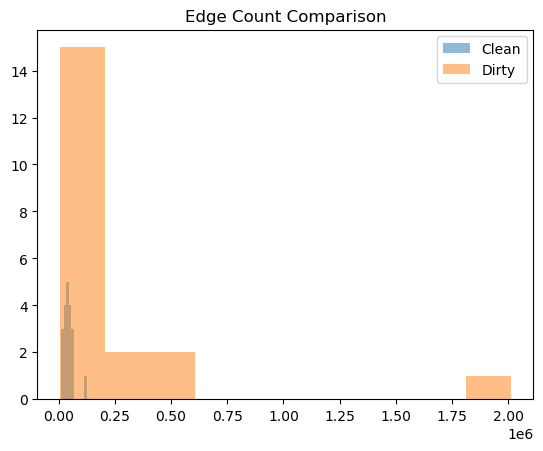

In [7]:
import matplotlib.pyplot as plt

df = pd.read_csv('features.csv')
labeled = df[df['label'] != 'unknown']

plt.hist(labeled[labeled['label'] == 'clean']['edge_count'], alpha=0.5, label='Clean')
plt.hist(labeled[labeled['label'] == 'dirty']['edge_count'], alpha=0.5, label='Dirty')
plt.legend()
plt.title('Edge Count Comparison')
plt.show()
